# **Linear Modeling of House Price**

# 1. Introduction

## 2. Preparing the Dataset and Modules

In [1]:
import pandas as pd
import numpy as np
from modules.custom_estimator import HetRobustRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import seaborn as sns

# Setting pandas options
pd.set_option('display.float', '{:,.2f}'.format)
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 75)
pd.set_option('display.max_info_columns', 50)

# Preparing dataset
# Train set
X_train = pd.read_csv('Dataset\X_train.csv')
y_train = pd.read_csv('Dataset\y_train.csv')
# Test set
X_test = pd.read_csv('Dataset\X_test.csv')
y_test = pd.read_csv('Dataset\y_test.csv')

# 3. Linear Modeling: Ordinary Least Square

## 3.1. Simple Linear Regression

Let's first consider a very simple linear regression system using intercept and an explanatory variable. From previous chapter, we found that `building_size_m2` has the largest linear correlation coefficient to `price_in_rp`, our target variable.

In [2]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.api import OLS
from statsmodels.tools import add_constant

X = X_train[['building_size_m2']]
X = add_constant(X)
y = y_train
# regression formula:
# price_in_rp ~ intercept + building_size_m2
lm = OLS(y, X)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price_in_rp   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     2609.
Date:                Thu, 17 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:19:44   Log-Likelihood:                -74037.
No. Observations:                3068   AIC:                         1.481e+05
Df Residuals:                    3066   BIC:                         1.481e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -9.839e+08   1.64e+08     -5.992      0.000   -1.31e+09   -6.62e+08
building_size_m2  2.667e+07   5.22e+05     51.074      0.000    2.56e+07    2.77e+07
==============================================================================
Omnibus:                     5588.374   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11784169.280
Skew:                          12.971   Prob(JB):                         0.00
Kurtosis:                     305.508   Cond. No.                         391.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Very low negative intercept doesn't explain anything here. Furthermore, when our explanatory variable (`building_size_m2`) has 0 value, it has no meaning at all since it is logically false for a house with zero building size.

From now on, we won't consider intercept for our model.

In [3]:
X = X_train[['building_size_m2']]
y = y_train
# regression formula
# price_in_rp ~ building_size_m2
lm = OLS(y, X)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            price_in_rp   R-squared (uncentered):                   0.529
Model:                            OLS   Adj. R-squared (uncentered):              0.529
Method:                 Least Squares   F-statistic:                              3449.
Date:                Thu, 17 Nov 2022   Prob (F-statistic):                        0.00
Time:                        20:19:44   Log-Likelihood:                         -74055.
No. Observations:                3068   AIC:                                  1.481e+05
Df Residuals:                    3067   BIC:                                  1.481e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
building_size_m2  2.481e+07   4.23e+05     58.728      0.000     2.4e+07    2.56e+07
==============================================================================
Omnibus:                     5767.533   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12787156.786
Skew:                          13.930   Prob(JB):                         0.00
Kurtosis:                     318.046   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

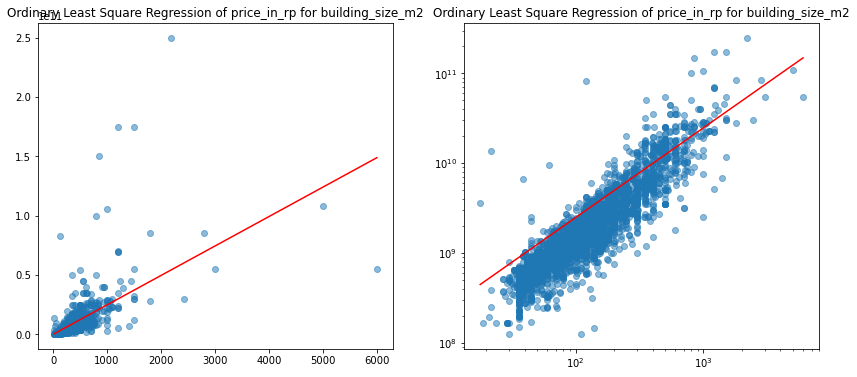

In [4]:
# linear OLS
y_linear = results.predict(X)
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(X.building_size_m2, y, alpha=0.5)
    ax_.plot(
        np.sort(X.building_size_m2),
        y_linear[np.argsort(X.building_size_m2)], color='r'
    )
    ax_.set_title('Ordinary Least Square Regression of price_in_rp for building_size_m2')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
 

Note that plot with `log scale axis` explains that linearity exist between our explanatory variable and our target variable, but don't be deceived by its equally spreaded (constance variance) response along the regression line because the actual meaning is that it confirms the response indeed spreads from the regression line as their center.

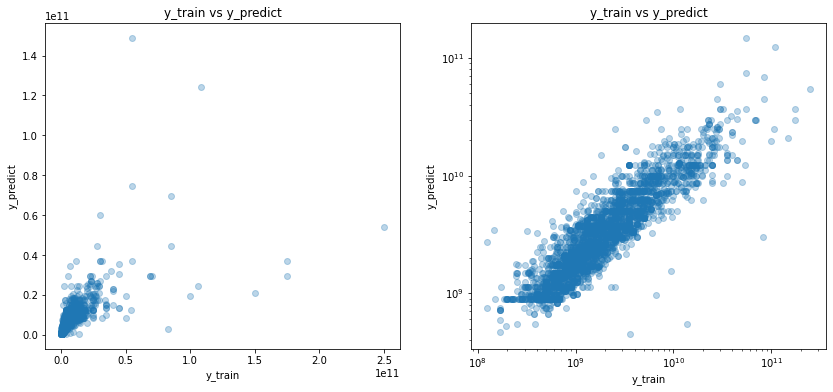

In [5]:
y_predict = results.predict(exog=X).values.reshape(-1, 1)
y = y_train.price_in_rp.values.reshape(-1, 1)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(x=y, y=y_predict, alpha=0.3)
    ax_.set_title('y_train vs y_predict')
    ax_.set_xlabel('y_train')
    ax_.set_ylabel('y_predict')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

#### **Residual Analysis of Simple Linear Regression**

Text(0, 0.5, 'residual')

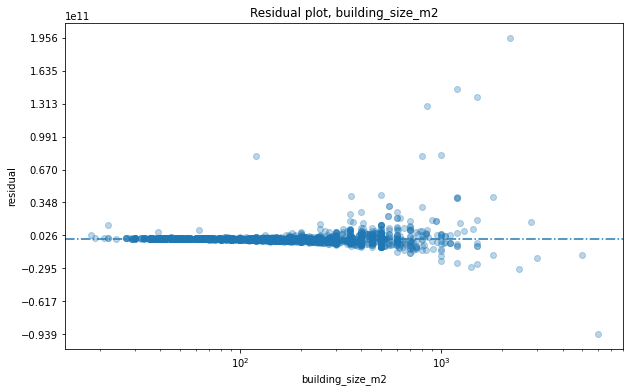

In [6]:
y_predict = results.predict(exog=X).values.reshape(-1, 1)
y = y_train.price_in_rp.values.reshape(-1, 1)
resid = y - y_predict
# matpltlib plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x=X_train.building_size_m2.values.reshape(-1, 1), y=resid, alpha=0.3)
ax.axhline(y=resid.mean(), linestyle='-.')
ax.set_title('Residual plot, building_size_m2')
ax.set_yticks(np.linspace(resid.min(), resid.max(), 10))
ax.set_xscale('log')
ax.set_xlabel('building_size_m2')
ax.set_ylabel('residual')

Text(0, 0.5, 'Residual')

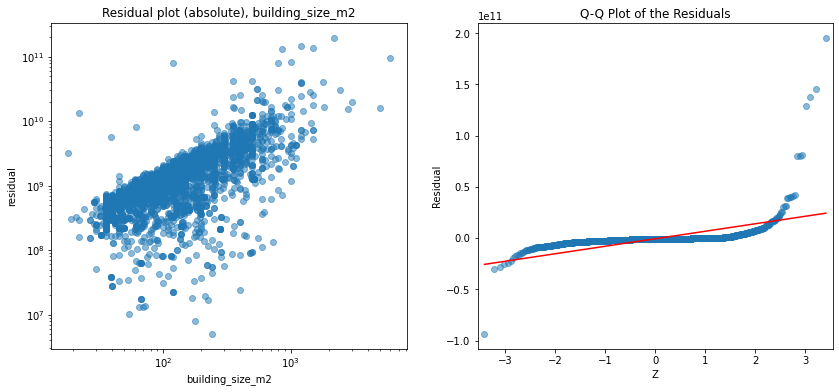

In [7]:
from statsmodels.graphics.gofplots import ProbPlot

# residual plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].scatter(x=X_train.building_size_m2.values.reshape(-1, 1), y=abs(resid), alpha=0.5)
ax[0].set_title('Residual plot (absolute), building_size_m2')
ax[0].set_yticks(np.linspace(resid.min(), resid.max(), 10))
ax[0].set_xscale('log') 
ax[0].set_yscale('log', nonpositive='mask')
ax[0].set_xlabel('building_size_m2')
ax[0].set_ylabel('residual')
# Q-Q Plot
pplot = ProbPlot(resid.flatten())
pplot.qqplot(ax=ax[1], alpha=0.5, line='s')
ax[1].set_title('Q-Q Plot of the Residuals')
ax[1].set_xlabel('Z')
ax[1].set_ylabel('Residual')

In [8]:
from statsmodels.stats.diagnostic import het_breuschpagan

exog_het = X_train['building_size_m2'].values.reshape(-1, 1)
# since auxillary regression of residual 
# must have an intercept constant:
exog_het = add_constant(exog_het) 
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(resid, exog_het, robust=True)
pd.DataFrame({
    'statistic': ['lagrange multiplier', 'f'],
    'statistic_value': [lm, fvalue],
    'p_value': [lm_pvalue, f_pvalue]
    })

,statistic,statistic_value,p_value
0,lagrange multiplier,273.16,0.00
1,f,299.67,0.00


Let's further verify this heteroscedacity condition by inspecting the influence of our observations data. Influence will be inspected using `studentized residual, leverage statistics, and cook's distance`, as of next section.

#### **Outliers Detection: Studentized Residual, Leverage Point, Cook Distance**

Text(0.5, 0, 'building_size_m2')

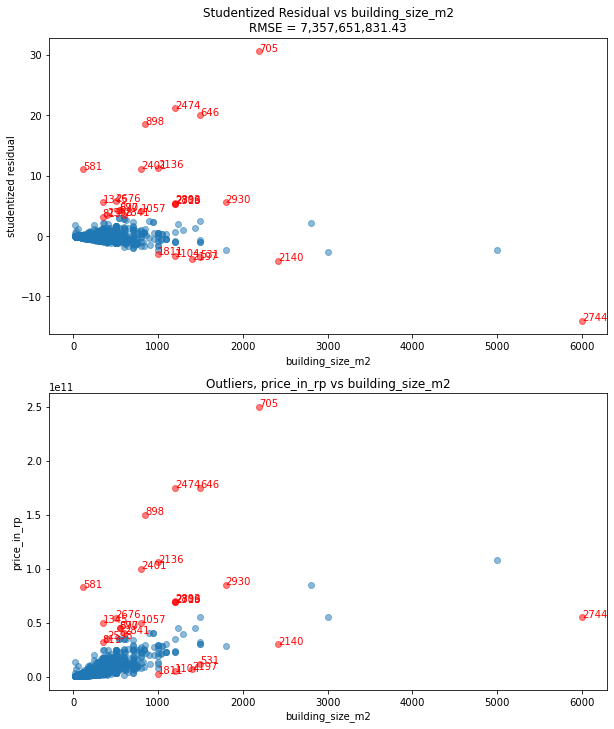

In [9]:
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
lm = OLS(y, X)
results = lm.fit()
y_hat = results.predict(X)
mse = mean_squared_error(y, y_hat)
student_resid = results.outlier_test()[:, 0]
outlier_obs = ((student_resid > 3) | (student_resid < -3))
outlier_obs_index = np.where(outlier_obs)[0]
# plot
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
# Studentized Residual Plot
ax[0].scatter(x=X[~outlier_obs], y=student_resid[~outlier_obs], alpha=0.5)
ax[0].scatter(x=X[outlier_obs], y=student_resid[outlier_obs], alpha=0.5, color='r', label='Outliers')
for x, student_resid, index in np.c_[X[outlier_obs], student_resid[outlier_obs], outlier_obs_index]:
    ax[0].text(x=x, y=student_resid, s=str(int(index)), color='r')
ax[0].set_ylabel('studentized residual')
ax[0].set_xlabel('building_size_m2')
ax[0].set_title(f'Studentized Residual vs building_size_m2\nRMSE = {np.sqrt(mse):,.2f}')
# Observations Plot
ax[1].scatter(x=X[~outlier_obs], y=y[~outlier_obs], alpha=0.5)
ax[1].scatter(x=X[outlier_obs], y=y[outlier_obs], alpha=0.5, color='r', label='Outliers')
for x, y, index in np.c_[X[outlier_obs], y[outlier_obs], outlier_obs_index]:
    ax[1].text(x=x, y=y, s=str(int(index)), color='r')
ax[1].set_title('Outliers, price_in_rp vs building_size_m2')
ax[1].set_ylabel('price_in_rp')
ax[1].set_xlabel('building_size_m2')

Text(0.5, 0, 'building_size_m2')

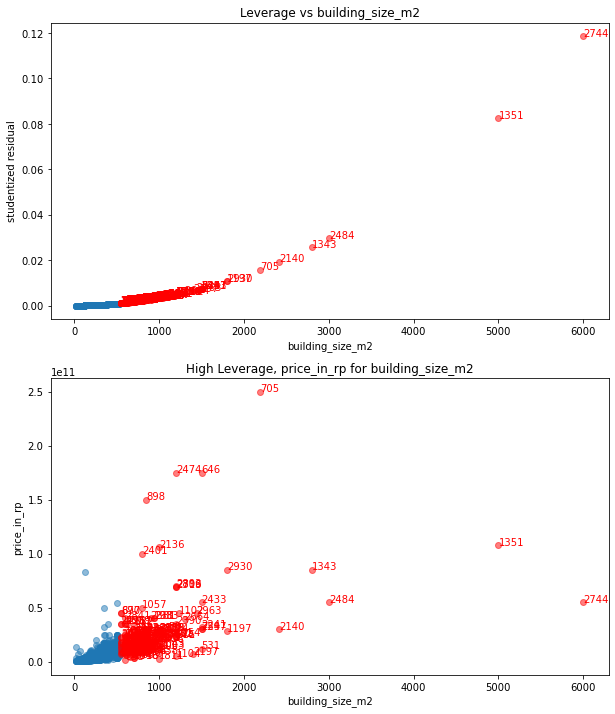

In [10]:
# getting leverage statistics
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
lm = OLS(y, X)
results = lm.fit()
leverage = results.get_influence().hat_matrix_diag
high_leverag_tresh = 3 * (1) / (X.shape[0])
high_leverage_obs = (leverage > high_leverag_tresh)
high_leverage_obs_index = np.where(high_leverage_obs)[0]
# Plot Leverage Statistics
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
ax[0].scatter(
    x=X[~high_leverage_obs], y=leverage[~high_leverage_obs], alpha=0.5)
ax[0].scatter(
    x=X[high_leverage_obs], y=leverage[high_leverage_obs], 
    alpha=0.5, color='r', label='high leverage')
for x, leverage, index in np.c_[X[high_leverage_obs], leverage[high_leverage_obs], high_leverage_obs_index]:
    ax[0].text(x=x, y=leverage, s=str(int(index)), color='r')
ax[0].set_ylabel('studentized residual')
ax[0].set_xlabel('building_size_m2')
ax[0].set_title('Leverage vs building_size_m2')
# Observations Plot
ax[1].scatter(x=X[~high_leverage_obs], y=y[~high_leverage_obs], alpha=0.5)
ax[1].scatter(x=X[high_leverage_obs], y=y[high_leverage_obs], alpha=0.5, color='r', label='Outliers')
for x, y, index in np.c_[X[high_leverage_obs], y[high_leverage_obs], high_leverage_obs_index]:
    ax[1].text(x=x, y=y, s=str(int(index)), color='r')
ax[1].set_title('High Leverage, price_in_rp for building_size_m2')
ax[1].set_ylabel('price_in_rp')
ax[1].set_xlabel('building_size_m2')

Text(0.5, 0, 'building_size_m2')

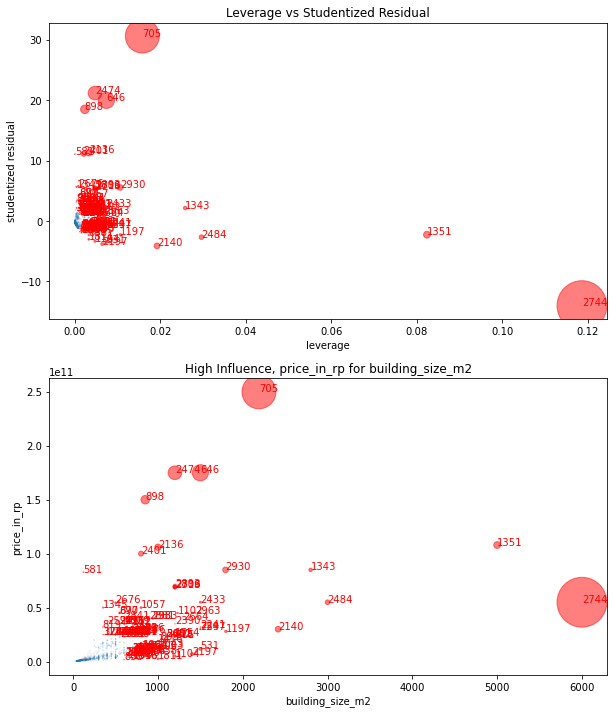

In [11]:
# Cook Distance
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
lm = OLS(y, X)
results = lm.fit()
student_resid = results.outlier_test()[:, 0]
leverage = results.get_influence().hat_matrix_diag
cooks_dist = results.get_influence().cooks_distance[0]
high_influence_obs = (cooks_dist > 4 / (X.shape[0] - 1))
high_influence_obs_index = np.where(high_influence_obs)[0]
# High Influence Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
ax[0].scatter(
    x=leverage[~high_influence_obs], y=student_resid[~high_influence_obs], 
    s= cooks_dist[~high_influence_obs] * 100, alpha=0.5)
ax[0].scatter(
    x=leverage[high_influence_obs], y=student_resid[high_influence_obs], 
    alpha=0.5, color='r', s=cooks_dist[high_influence_obs] * 100,
    label='high influence')
for lev, stud_resid, index in np.c_[
    leverage[high_influence_obs], student_resid[high_influence_obs], high_influence_obs_index]:
    ax[0].text(x=lev, y=stud_resid, s=str(int(index)), color='r')
ax[0].set_ylabel('studentized residual')
ax[0].set_xlabel('leverage')
ax[0].set_title('Leverage vs Studentized Residual')
# Observations Plot
ax[1].scatter(
    x=X[~high_influence_obs], y=y[~high_influence_obs], 
    s=cooks_dist[~high_influence_obs] * 100, alpha=0.5)
ax[1].scatter(
    x=X[high_influence_obs], y=y[high_influence_obs], 
    s=cooks_dist[high_influence_obs] * 100, alpha=0.5, color='r', label='Outliers')
for x, y, index in np.c_[X[high_influence_obs], y[high_influence_obs], high_influence_obs_index]:
    ax[1].text(x=x, y=y, s=str(int(index)), color='r')
ax[1].set_title('High Influence, price_in_rp for building_size_m2')
ax[1].set_ylabel('price_in_rp')
ax[1].set_xlabel('building_size_m2')

In [12]:
X_train.iloc[[11, 493, 581], :16].T

,11,493,581
certificate,shm - sertifikat hak milik,shm - sertifikat hak milik,shm - sertifikat hak milik
property_condition,bagus,baru,butuh renovasi
furnishing,unfurnished,unfurnished,unfurnished
city,Depok,Depok,Jakarta Barat
lat,-6.40,-6.37,-6.20
long,106.77,106.82,106.80
bedrooms,1,2,5
bathrooms,1,1,3
land_size_m2,72.00,46.00,"1,076.00"
building_size_m2,43.00,36.00,120.00


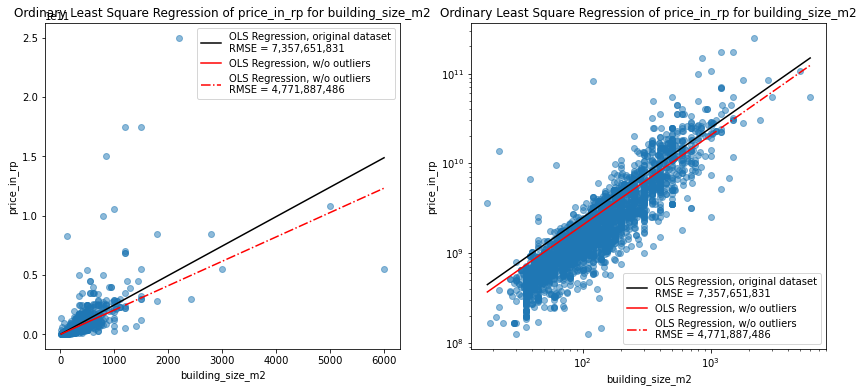

In [13]:
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
lm_1 = OLS(y, X)
lm_2 = OLS(y[~high_influence_obs], X[~high_influence_obs])
prediction_range = np.max(X[~high_influence_obs])
results_1 = lm_1.fit()
results_2 = lm_2.fit()
y_predict_1 = results_1.predict(X)
y_predict_2 = results_2.predict(X[X <= prediction_range])
y_predict_2_extr = results_2.predict(X[X > prediction_range])
mse_1 = mean_squared_error(y, y_predict_1)
mse_2 = mean_squared_error(y[X <= prediction_range], y_predict_2)
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(X, y, alpha=0.5)
    ax_.plot(
        np.sort(X),
        y_predict_1[np.argsort(X)], color='black',
        label=f'OLS Regression, original dataset\nRMSE = {np.sqrt(mse_1):,.0f}'       
    )
    ax_.plot(
        np.sort(X[X <= prediction_range]),
        y_predict_2[np.argsort(X[X <= prediction_range])], color='r',
        label='OLS Regression, w/o outliers'
    )
    ax_.plot(
        np.sort(X[X > prediction_range]),
        y_predict_2_extr[np.argsort(X[X > prediction_range])], linestyle='-.', color='r',
        label=f'OLS Regression, w/o outliers\nRMSE = {np.sqrt(mse_2):,.0f}'
    )    
    ax_.set_title('Ordinary Least Square Regression of price_in_rp for building_size_m2')
    ax_.legend()
    ax_.set_xlabel('building_size_m2')
    ax_.set_ylabel('price_in_rp')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [14]:
results_2.summary().tables[0]

Dep. Variable:,y,R-squared (uncentered):,0.833
Model:,OLS,Adj. R-squared (uncentered):,0.833
Method:,Least Squares,F-statistic:,1.477e+04
Date:,"Thu, 17 Nov 2022",Prob (F-statistic):,0.00
Time:,20:20:06,Log-Likelihood:,-67590.
No. Observations:,2963,AIC:,1.352e+05
Df Residuals:,2962,BIC:,1.352e+05
Df Model:,1,,
Covariance Type:,nonrobust,,


In [15]:
results_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
x1,2.054e+07,1.69e+05,121.530,0.000,2.02e+07,2.09e+07


#### **Dealing with Non-Constant Variance**

We will use `Weighted OLS` to address non-constant variance in the data. For this dataset, we will use `Regression Robust to Heteroscedacity` provided in `modules` directory, which developed according to Atkinson et al., 2016<sup>[1]</sup>. Sample weight is estimated using parametric formula and iteration algorithm explained in that same scientific journal.

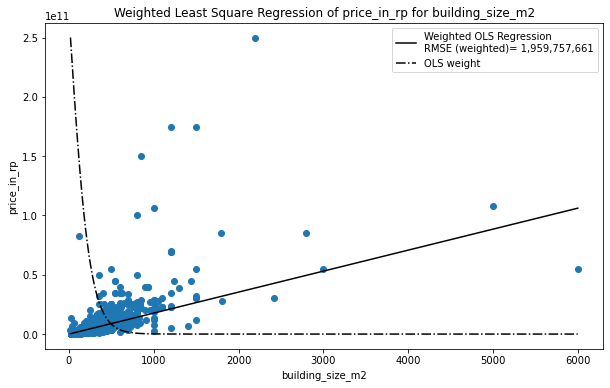

In [16]:
X = X_train['building_size_m2'].values.reshape(-1, 1)
y = y_train['price_in_rp'].values
robust_reg = HetRobustRegression(fit_intercept=False)
# Weighted OLS with full dataset
lm_3a = robust_reg.fit(X, y, X)
y_predict_3a = robust_reg.predict(X)
sample_weight_a = lm_3a.weight_
sample_weight_a_normlzd = \
    (sample_weight_a - np.min(sample_weight_a)) / (np.max(sample_weight_a) - np.min(sample_weight_a))
scaled_weight_a = sample_weight_a_normlzd * np.max(y)
mse_3a = mean_squared_error(y, y_predict_3a, sample_weight=sample_weight_a)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x=X, y=y)
ax.plot(
    np.sort(X.flatten()), 
    y_predict_3a [np.argsort(X.flatten())], color='black',
    label=f'Weighted OLS Regression\nRMSE (weighted)= {np.sqrt(mse_3a):,.0f}',
    )
ax.plot(
    np.sort(X.flatten()), 
    scaled_weight_a[np.argsort(X.flatten())], color='black',
    label='OLS weight', ls='-.'
    )
ax.set_title('Weighted Least Square Regression of price_in_rp for building_size_m2')
ax.set_xlabel('building_size_m2')
ax.set_ylabel('price_in_rp')
ax.legend()

Text(0.5, 0, 'building_size_m2')

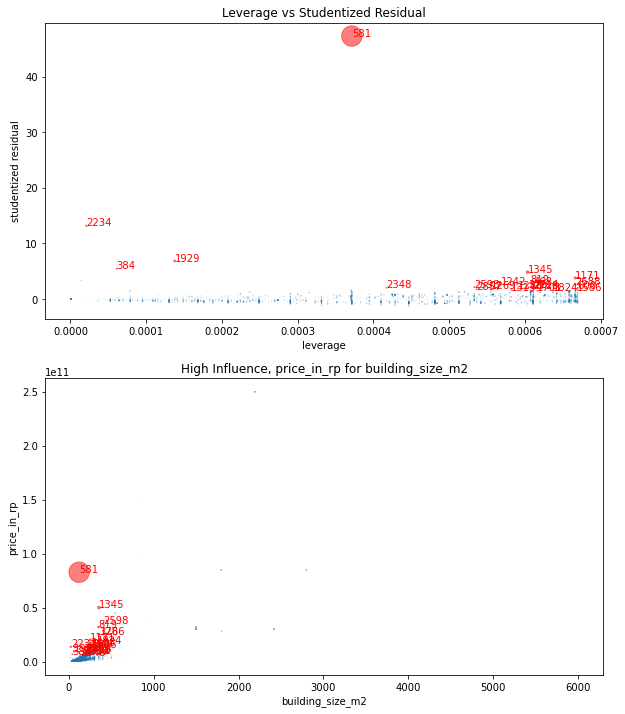

In [17]:
from scipy.sparse import diags

# Cook Distance
X = X_train['building_size_m2'].values.reshape(-1, 1)
y = y_train['price_in_rp'].values
W = diags(sample_weight_a)
p = X.shape[1] # no intercept
resid = sample_weight_a*(y - y_predict_3a)
se2 = np.square(np.linalg.norm(resid)) / (len(y) - p) # se2 = SSE / (n - p), p = 1 since no intercept
h = np.diag(X @ np.linalg.inv((X.T) @ W @ X) @ (X.T) @ W) # leverage is (weighted) hat matrix diagonal
student_resid = resid / np.sqrt(se2 * (1 - h))
cooks_dist = (np.square(resid) / (p * se2)) * (h / np.square(1 - h))
high_influence_obs = (cooks_dist > (4 / (X.shape[0] - p)))
high_influence_obs_index = np.where(high_influence_obs)[0]
# High Influence Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
ax[0].scatter(
    x=h[~high_influence_obs], y=student_resid[~high_influence_obs], 
    s= cooks_dist[~high_influence_obs] * 500, alpha=0.5)
ax[0].scatter(
    x=h[high_influence_obs], y=student_resid[high_influence_obs], 
    alpha=0.5, color='r', s=cooks_dist[high_influence_obs] * 500,
    label='high influence')
for lev, stud_resid, index in np.c_[
    h[high_influence_obs], student_resid[high_influence_obs], high_influence_obs_index]:
    ax[0].text(x=lev, y=stud_resid, s=str(int(index)), color='r')
ax[0].set_ylabel('studentized residual')
ax[0].set_xlabel('leverage')
ax[0].set_title('Leverage vs Studentized Residual')
# Observations Plot
ax[1].scatter(
    x=X[~high_influence_obs], y=y[~high_influence_obs], 
    s=cooks_dist[~high_influence_obs] * 500, alpha=0.5)
ax[1].scatter(
    x=X[high_influence_obs], y=y[high_influence_obs], 
    s=cooks_dist[high_influence_obs] * 500, alpha=0.5, color='r', label='Outliers')
for x, y, index in np.c_[X[high_influence_obs], y[high_influence_obs], high_influence_obs_index]:
    ax[1].text(x=x, y=y, s=str(int(index)), color='r')
ax[1].set_title('High Influence, price_in_rp for building_size_m2')
ax[1].set_ylabel('price_in_rp')
ax[1].set_xlabel('building_size_m2')

Note that our weighted least square doesn't identify larger `building_size_m2` as a high influence, since it already considered them as their weight. The estimator now focuses more closer to higher-weighted samples (i.e. small `building_size_m2`). And also note some of the index that are presented in previous `outliers marker` are also shown in above. 

Let's zoom in onto this range. 

(0.0, 400.0)

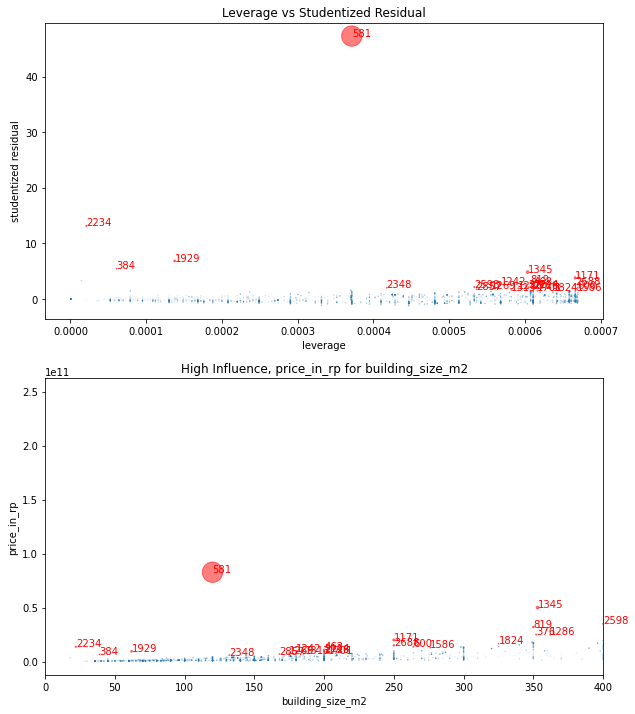

In [18]:
X = X_train['building_size_m2'].values.reshape(-1, 1)
y = y_train['price_in_rp'].values
# High Influence Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
ax[0].scatter(
    x=h[~high_influence_obs], y=student_resid[~high_influence_obs], 
    s= cooks_dist[~high_influence_obs] * 500, alpha=0.5)
ax[0].scatter(
    x=h[high_influence_obs], y=student_resid[high_influence_obs], 
    alpha=0.5, color='r', s=cooks_dist[high_influence_obs] * 500,
    label='high influence')
for lev, stud_resid, index in np.c_[
    h[high_influence_obs], student_resid[high_influence_obs], high_influence_obs_index]:
    ax[0].text(x=lev, y=stud_resid, s=str(int(index)), color='r')
ax[0].set_ylabel('studentized residual')
ax[0].set_xlabel('leverage')
ax[0].set_title('Leverage vs Studentized Residual')
# Observations Plot
ax[1].scatter(
    x=X[~high_influence_obs], y=y[~high_influence_obs], 
    s=cooks_dist[~high_influence_obs] * 500, alpha=0.5)
ax[1].scatter(
    x=X[high_influence_obs], y=y[high_influence_obs], 
    s=cooks_dist[high_influence_obs] * 500, alpha=0.5, color='r', label='Outliers')
for x, y, index in np.c_[X[high_influence_obs], y[high_influence_obs], high_influence_obs_index]:
    ax[1].text(x=x, y=y, s=str(int(index)), color='r')
ax[1].set_title('High Influence, price_in_rp for building_size_m2')
ax[1].set_ylabel('price_in_rp')
ax[1].set_xlabel('building_size_m2')
ax[1].set_xlim(0, 400)

Now let's finalize our model to exclude those high influence observations.

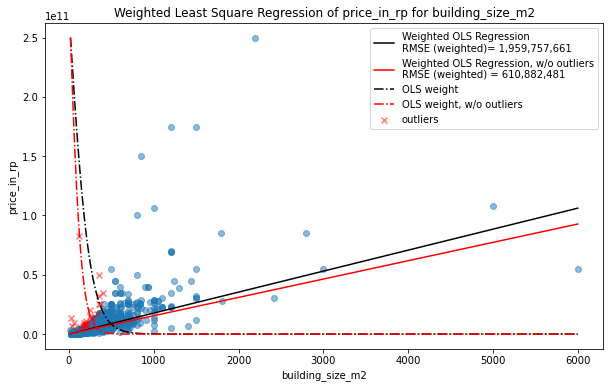

In [19]:
X = X_train['building_size_m2'].values.reshape(-1, 1)
y = y_train['price_in_rp'].values
# Weighted OLS without outliers
lm_3b = robust_reg.fit(X[~high_influence_obs], y[~high_influence_obs], X[~high_influence_obs])
y_predict_3b = robust_reg.predict(X[~high_influence_obs])
sample_weight_b = lm_3b.weight_
sample_weight_b_normlzd = \
    (sample_weight_b - np.min(sample_weight_b)) / (np.max(sample_weight_b) - np.min(sample_weight_b))
scaled_weight_b = sample_weight_b_normlzd * np.max(y)
mse_3b = mean_squared_error(y[~high_influence_obs], y_predict_3b, sample_weight=sample_weight_b)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x=X[~high_influence_obs], y=y[~high_influence_obs], alpha=0.5)
ax.scatter(
    x=X[high_influence_obs], y=y[high_influence_obs], 
    marker='x', color='r',alpha=0.5, label='outliers'
    )
ax.plot(
    np.sort(X.flatten()), 
    y_predict_3a[np.argsort(X.flatten())], color='black',
    label=f'Weighted OLS Regression\nRMSE (weighted)= {np.sqrt(mse_3a):,.0f}',
    )
ax.plot(
    np.sort(X[~high_influence_obs].flatten()), 
    y_predict_3b[np.argsort(X[~high_influence_obs].flatten())], color='red',
    label=f'Weighted OLS Regression, w/o outliers\nRMSE (weighted) = {np.sqrt(mse_3b):,.0f}',
    )
ax.plot(
    np.sort(X.flatten()), 
    scaled_weight_a[np.argsort(X.flatten())], color='black',
    label='OLS weight', ls='-.'
    )
ax.plot(
    np.sort(X[~high_influence_obs].flatten()), 
    scaled_weight_b[np.argsort(X[~high_influence_obs].flatten())], color='red',
    label='OLS weight, w/o outliers', ls='-.'
    )
ax.set_title('Weighted Least Square Regression of price_in_rp for building_size_m2')
ax.set_xlabel('building_size_m2')
ax.set_ylabel('price_in_rp')
ax.legend()

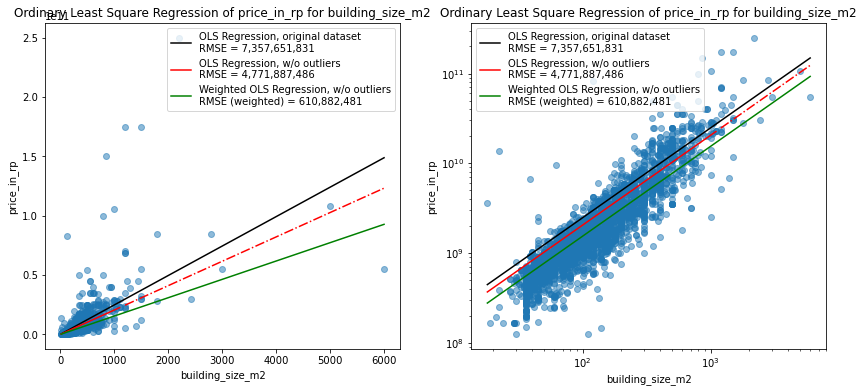

In [20]:
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(X, y, alpha=0.5)
    ax_.plot(
        np.sort(X),
        y_predict_1[np.argsort(X)], color='black',
        label=f'OLS Regression, original dataset\nRMSE = {np.sqrt(mse_1):,.0f}'       
    )
    ax_.plot(
        np.sort(X[X <= prediction_range]),
        y_predict_2[np.argsort(X[X <= prediction_range])], color='r',
        label=f'OLS Regression, w/o outliers\nRMSE = {np.sqrt(mse_2):,.0f}'
    )
    ax_.plot(
        np.sort(X[X > prediction_range]),
        y_predict_2_extr[np.argsort(X[X > prediction_range])], linestyle='-.', color='r',
    )
    ax_.plot(
        np.sort(X[~high_influence_obs].flatten()), 
        y_predict_3b[np.argsort(X[~high_influence_obs].flatten())], color='green',
        label=f'Weighted OLS Regression, w/o outliers\nRMSE (weighted) = {np.sqrt(mse_3b):,.0f}',
    )  
    ax_.set_title('Ordinary Least Square Regression of price_in_rp for building_size_m2')
    ax_.legend()
    ax_.set_xlabel('building_size_m2')
    ax_.set_ylabel('price_in_rp')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

#### **Inference of `building_size_m2` parameter  and `mean response`**

We are going to use `wild bootstrap` to estimate distribution of `building_size_m2` parameter.

In [21]:
def coefficient(x, y_null, boot_resid):
    epsilon = np.random.choice([1, -1], len(y_null), p=[0.5, 0.5]) # Flachair's pick distribution
    boot_resid_ = boot_resid.flatten()
    resid_dgp = boot_resid_ * epsilon
    y_dgp = (y_null + resid_dgp).flatten()
    lm_boots = OLS(y_dgp, x)
    result_boots = lm_boots.fit()
    coef_boots = result_boots.params[0]
    return coef_boots

X = X_train['building_size_m2'].values.reshape(-1, 1)[~high_influence_obs]
y = y_train['price_in_rp'].values[~high_influence_obs]
# prediction
lm = HetRobustRegression(fit_intercept=False)
results = lm.fit(X, y, X)
y_predict = results.predict(X) # y_predict here serves beta as the null hypotheses for bootstrap
coef = results.coef_
# calculate hat matrix
h = np.diag(X @ np.linalg.inv((X.T) @ X) @ (X.T)) #  = h_t in Flachair (2003)
# calculate adjusted residual
residual = y - y_predict # = OLS restricted residuals in Flachair (2003)
a = 1/ (1 - h) # using HC3 as proposed by Flachair (2003)
resid = a * residual
# bootstrap
arr = np.empty(len(y))
sample = (arr, )
confidence_level = 0.95
lower_tail = (1 - confidence_level) / 2
upper_tail = 1 - lower_tail 
bootstrap_res = bootstrap(
    sample, lambda arr: coefficient(X, y_predict, resid), vectorized=False, 
    confidence_level=confidence_level, method='percentile'
)
pd.DataFrame([
    {'model': 'Weighted OLS, w/o outliers', 
    'coef': coef[0],
    f'ci_low ({lower_tail:.3f})': bootstrap_res.confidence_interval[0],
    f'ci_high({upper_tail:.3f})': bootstrap_res.confidence_interval[1]}
    ])

,model,coef,ci_low (0.025),ci_high(0.975)
0,"Weighted OLS, w/o outliers","15,461,356.16","11,051,329.31","19,866,949.07"


Compare it to interval calculated using *student's t distribution* based on standard error of the coefficient:

In [22]:
results_2.summary(alpha=0.05).tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
x1,2.054e+07,1.69e+05,121.530,0.000,2.02e+07,2.09e+07


For large sample, it is known that inference of regression coefficient *using student's t-distribution* will covers the *violation of normality* since *t-distribution will converge to normal*, but we won't know for sure how large of `n sample` is large enough for our dataset. But what is known that the largeness of `n` is highly affected by dataset skewness, in which our dataset suffers highly. Our model with `building_size_m2` also suffers from `non-constant variance`, which also affect the validity of our *t-distribution*.

The confidence interval is quite narrow (compared to the bootstrap result). The safer choice will be the `bootstrap confidence interval` due to reasons above.

As we hope that the bootstrap result portrays the true distribution of coefficient onfidently (we followed wild bootstrap method to achieve unbiased regression DGP and we assume that the dataset covers the population data well enough), the possibility of `building_size_m2` value can be identified by using below bootstrap plot.

Text(0, 0.5, 'coeff value')

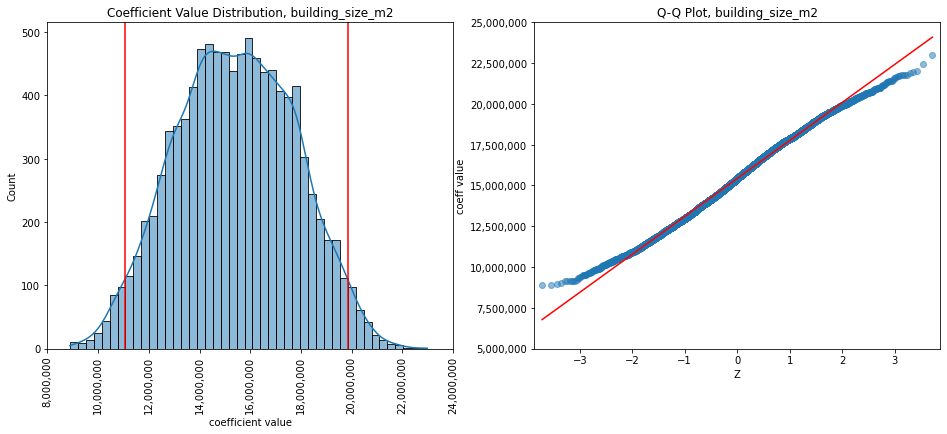

In [23]:
# bootstrapping
n_iter = 9999
arr = np.empty((n_iter, 1))
bootstrap_coeff_value = \
    np.apply_along_axis(lambda x: coefficient(X, y_predict, resid), 1, arr)
# plotting bootstrap result
conf_low = bootstrap_res.confidence_interval[0]
conf_high = bootstrap_res.confidence_interval[1]
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(
    x=bootstrap_coeff_value, kde=True, ax=ax[0]
    )
ax[0].axvline(conf_low, color='r')
ax[0].axvline(conf_high, color='r')
xticks = ax[0].get_xticks()
ax[0].set_title('Coefficient Value Distribution, building_size_m2')
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(['{:,.0f}'.format(x) for x in xticks], rotation=90)
ax[0].set_xlabel('coefficient value')
# Q-Q Plot
pplot = ProbPlot(bootstrap_coeff_value.flatten())
pplot.qqplot(ax=ax[1], alpha=0.5, line='s')
yticks = ax[1].get_yticks()
ax[1].set_yticks(yticks)
ax[1].set_yticklabels(['{:,.0f}'.format(y) for y in yticks])
ax[1].set_title('Q-Q Plot, building_size_m2')
ax[1].set_xlabel('Z')
ax[1].set_ylabel('coeff value')

As seen above, the coefficient distribution is quite skewed, which not yet close to our `symmetric t-distribution` caused by incorrect t-distribution due to non-constant variance. 

The distribution is also fat-tailed, in which the sample size effect doesn't quite make the distribution *converge to normality* yet.

Both the skewed and fat-tailed distribution will be considered in `BCa Corrected Interval` that has been calculated by using `scipy.stats.bootstrap` program, making the `bootstrap ci` resulting in the more confidence choice of CI calculation.

Since our regression formula `y = 15,461,356.16 * X` here gives `conditional mean of price_price_in_rp at particular building_size_m2: mean y given X=x*`, confidence interval of X parameter will able to provide ` inference of mean y at 95% confidence level`.

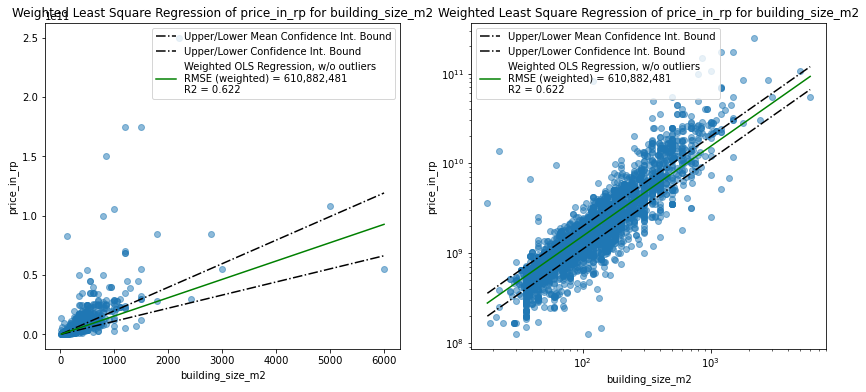

In [24]:
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
low_ci = (X * conf_low)
high_ci = (X * conf_high)
r2 = lm_3b.score(
    X[~high_influence_obs].reshape(-1, 1), 
    y[~high_influence_obs],
    X[~high_influence_obs].reshape(-1, 1))
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(X, y, alpha=0.5)
    ax_.plot(
        np.sort(X),
        high_ci[np.argsort(X)], color='black', ls='-.',
        label='Upper/Lower Mean Confidence Int. Bound'       
    )
    ax_.plot(
        np.sort(X),
        low_ci[np.argsort(X)], color='black', ls='-.',
        label='Upper/Lower Confidence Int. Bound'       
    )
    ax_.plot(
        np.sort(X[~high_influence_obs].flatten()), 
        y_predict_3b[np.argsort(X[~high_influence_obs].flatten())], color='green',
        label=\
            'Weighted OLS Regression, w/o outliers'
            f'\nRMSE (weighted) = {np.sqrt(mse_3b):,.0f}'
            f'\nR2 = {r2:.3f}'
    )  
    ax_.set_title('Weighted Least Square Regression of price_in_rp for building_size_m2')
    ax_.legend()
    ax_.set_xlabel('building_size_m2')
    ax_.set_ylabel('price_in_rp')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

#### **Prediction Interval of Simple Regression**

Prediction interval of a linear regression is an interval of plausible values of future Y at a specific value of parameter x*, which accounts for ***variance of mean response Y caused by variability of regression coefficient which accounted in regression model**, and **variability caused by error term which can't be explained in regression model***. 

Recall from previous section, our *R2* value for this model is less than 0.5, explains that there were variability that can't be explained by the simple linear model. Plot of *Y_obs vs Y_predicted* also shows unexplained variance of the response by using only `building_size_m2`.

The error term variability can also be seen in residual plot, where the residual is quite condensed in small `building_size_m2` but continue to spread out in large `building_size_m2` (i.e. indicating non-constant variance).

Theoretical prediction interval of OLS relies heavily on *normality assumption* and *constant variance*, which is violated by our simple linear model.

Let's see the calculated prediction interval by our Simple Linear Model, which is simply calculated by assumming the normality and constant variance is valid.

Text(0.5, 1.0, 'Ordinary Least Square Regression of price_in_rp for building_size_m2')

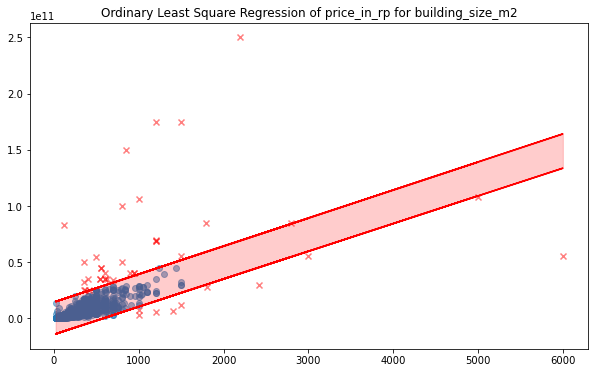

In [25]:
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
lm = OLS(y, X)
results = lm.fit()
y_predict = results.get_prediction(X).summary_frame(0.05)
pi_lower = y_predict.obs_ci_lower
pi_upper = y_predict.obs_ci_upper
outside_pi = np.logical_or(y > pi_upper, y < pi_lower)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(
    x=X[~outside_pi], 
    y=y[~outside_pi], alpha=0.5
    )
ax.scatter(
    x=X[outside_pi], 
    y=y[outside_pi], alpha=0.5,
    color='red', marker='x' 
    )
ax.plot(X, pi_lower, color='r', label='Lower Prediction Interval')
ax.plot(X, pi_upper, color='r', label='Upper Prediction Interval')
ax.fill_between(
    x=np.sort(X), y1=pi_lower[np.argsort(X)], y2=pi_upper[np.argsort(X)], alpha=0.2, color='r'
)
ax.set_title('Ordinary Least Square Regression of price_in_rp for building_size_m2')

In [26]:
# from scipy.sparse import diags

# def residual_distribution(x, y_estimate, x_pred, y_pred, adj_resid):
#     X_ = x.copy()
#     y_estimate_ = y_estimate.copy()
#     adj_resid_ = adj_resid.copy()
#     y = y_estimate_ + adj_resid_
#     lm_boots = OLS(y, add_constant(X_))
#     result_boots = lm_boots.fit()
#     y_boots = result_boots.predict(add_constant(X_))
#     residual_boots = y - y_boots
#     leverage_boots = result_boots.get_influence().hat_matrix_diag
#     s_boots = residual_boots / np.sqrt(1 - leverage_boots)
#     adj_resids_boots = s_boots - np.mean(s_boots)
#     y_pred_boots = result_boots.predict(np.array([1, x_pred]))
#     residual_future = \
#         y_pred - float(y_pred_boots) + float(np.random.choice(adj_resids_boots, 1))
#     return residual_future
    
# X = X_train['building_size_m2'].values.reshape(-1, 1)[~outlier_obs]
# y = y_train['price_in_rp'].values[~outlier_obs]
# # prediction
# lm = HetRobustRegression(fit_intercept=False)
# results = lm.fit(X, y, X)
# y_predict = results.predict(X)
# # calculate hat matrix
# weight = results.weight_
# W = diags(weight).toarray()
# h = np.linalg.inv((X.T) @ W @ X) @ (X.T) @ W #  = h_t in Flachair (2003)
# # calculate adjusted residual
# residual = y - y_predict # = OLS restricted residuals in Flachair (2003)
# a = 1/ (1 - h) # using HC3 as proposed by Flachair (2003)
# epsilon = np.random.choice([1, -1], len(y), p=[0.5, 0.5]) # Flachair's pick distribution
# s = a * residual * epsilon
# # bootstrapping interval
# observation_index = np.round(np.linspace(0, len(X) - 1, 5)).astype(int)
# x_future = X[X.argsort()][observation_index]
# y_future = results.predict(add_constant(x_future))
# residual_int_l = []
# residual_int_h = []
# sample = (s, )

#### **Predictive Performance of Simple Regression**

#### **Conclusion: Simple Linear Regression**

In [27]:
# X = X_train['building_size_m2'].values
# y = y_train['price_in_rp'].values
# # plot
# fig, ax = plt.subplots(figsize=(14, 6))
# sns.scatterplot(x=X, y=y, ax=ax)
# sns.lineplot(x=x_linear['building_size_m2'], y=y_linear, color='r', ax=ax)
# sns.lineplot(
#     data=prediction_interval_df, 
#     x='building_size', y='pi_l', color='g', ax=ax)
# sns.lineplot(
#     data=prediction_interval_df, 
#     x='building_size', y='pi_h', color='g', ax=ax)
# ax.fill_between(
#     data=prediction_interval_df,
#     x='building_size', y1='pi_h', y2='pi_l', alpha=0.1
# )
# ax.set_title('Ordinary Least Square Regression of price_in_rp for building_size_m2')

## 3.2. Multiple Linear Regression

In [28]:
train_set_transfd = pd.merge(
    X_train, y_train, left_index=True, right_index=True
    )
numerical_features = \
    X_train.select_dtypes(exclude=['object', 'category']).drop(['lat', 'long'], axis=1).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
f = 'price_in_rp ~ '\
    + ' + '.join(numerical_features) + ' - 1 + '
f += 'C(certificate, Treatment(reference=3)) + ' # `SHM` as reference
f += 'C(property_condition, Treatment(reference=3)) + ' # `butuh renovasi` as reference
f += 'C(furnishing, Treatment(reference=2)) + '  # `unfurnished` as reference
f += 'C(city, Treatment(reference=0))' # `Bekasi` as reference

lm = OLS.from_formula(f, data=train_set_transfd)
results = lm.fit()

What have we done using above codes?

1. 
2.

Text(0, 0.5, 'residual')

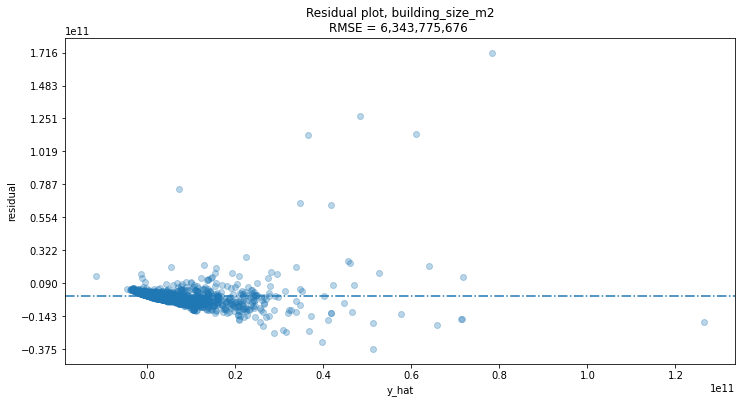

In [29]:
y = y_train.values.flatten()
y_hat = results.predict(train_set_transfd)
resid = train_set_transfd.price_in_rp - y_hat
mse = mean_squared_error(y, y_hat)
# matpltlib plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x=y_hat, y=resid, alpha=0.3)
ax.axhline(y=resid.mean(), linestyle='-.')
ax.set_title(f'Residual plot, building_size_m2\nRMSE = {np.sqrt(mse):,.0f} ')
ax.set_yticks(np.linspace(resid.min(), resid.max(), 10))
ax.set_xlabel('y_hat')
ax.set_ylabel('residual')

In [30]:
results.summary().tables[0]

Dep. Variable:,price_in_rp,R-squared:,0.594
Model:,OLS,Adj. R-squared:,0.586
Method:,Least Squares,F-statistic:,73.21
Date:,"Thu, 17 Nov 2022",Prob (F-statistic):,0.00
Time:,20:21:16,Log-Likelihood:,-73600.
No. Observations:,3068,AIC:,1.473e+05
Df Residuals:,3007,BIC:,1.477e+05
Df Model:,60,,
Covariance Type:,nonrobust,,


In [31]:
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
"C(certificate, Treatment(reference=3))[hgb - hak guna bangunan]",1.207e+09,1.09e+09,1.111,0.267,-9.23e+08,3.34e+09
"C(certificate, Treatment(reference=3))[hp - hak pakai]",1.807e+09,6.51e+09,0.277,0.781,-1.1e+10,1.46e+10
"C(certificate, Treatment(reference=3))[lainnya (ppjb,girik,adat,dll)]",1.946e+09,1.04e+09,1.869,0.062,-9.52e+07,3.99e+09
"C(certificate, Treatment(reference=3))[shm - sertifikat hak milik]",1.857e+09,9.73e+08,1.907,0.057,-5.21e+07,3.77e+09
"C(property_condition, Treatment(reference=3))[T.bagus]",-1.815e+09,8.01e+08,-2.266,0.024,-3.39e+09,-2.45e+08
"C(property_condition, Treatment(reference=3))[T.bagus sekali]",-2.871e+09,9.04e+08,-3.175,0.002,-4.64e+09,-1.1e+09
"C(property_condition, Treatment(reference=3))[T.baru]",-1.127e+09,8.16e+08,-1.381,0.167,-2.73e+09,4.73e+08
"C(property_condition, Treatment(reference=3))[T.sudah renovasi]",-2.412e+09,9.69e+08,-2.489,0.013,-4.31e+09,-5.12e+08
"C(furnishing, Treatment(reference=2))[T.furnished]",-1.496e+08,5.14e+08,-0.291,0.771,-1.16e+09,8.58e+08
"C(furnishing, Treatment(reference=2))[T.semi furnished]",-4.849e+08,3.36e+08,-1.443,0.149,-1.14e+09,1.74e+08


#### **Multicollinearity**

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# We need to encode categorical variable first
dummy_reference = [
    'city_ Bekasi', 'furnishing_unfurnished', 
    'property_condition_butuh renovasi', 'certificate_shm - sertifikat hak milik']
X_train_encoded = \
    pd.get_dummies(X_train, columns=categorical_features)\
        .drop(dummy_reference, axis=1)\
        .drop(['lat', 'long'], axis=1)
X_train_encoded = X_train_encoded
pd.DataFrame({
    'vif': 
        [variance_inflation_factor(X_train_encoded, i) for i in range(X_train_encoded.shape[1])]
    },
    index=X_train_encoded.columns
    ).sort_values(by='vif', ascending=False)

d:\anaconda3\envs\general_ds\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,vif
fac_gudang,inf
fac_basement,inf
bedrooms,26.05
bathrooms,22.67
floors,12.46
fac_keamanan,9.91
property_condition_bagus,9.53
fac_garden,9.25
property_condition_baru,8.13
building_size_m2,5.65


In [33]:
high_vif_features = [
    'fac_basement', 'fac_gudang', 'bedrooms', 'bathrooms',
    'floors', 'fac_keamanan', 'fac_garden', 
]
dummy_reference = [
    'city_ Bekasi', 'furnishing_unfurnished', 
    'property_condition_butuh renovasi', 'certificate_shm - sertifikat hak milik']
X_train_encoded = \
    pd.get_dummies(X_train, columns=categorical_features)\
        .drop(dummy_reference, axis=1)\
        .drop(['lat', 'long'], axis=1)\
        .drop(high_vif_features, axis=1)
X_train_encoded = X_train_encoded
pd.DataFrame({
    'vif': 
        [variance_inflation_factor(X_train_encoded, i) for i in range(X_train_encoded.shape[1])]
    },
    index=X_train_encoded.columns
    ).sort_values(by='vif', ascending=False)

,vif
building_size_m2,4.91
property_condition_bagus,4.21
property_condition_baru,4.17
maid_bedrooms,4.03
maid_bathrooms,4.01
electricity_num,3.72
fac_jogging_track,2.94
carports,2.87
fac_ac,2.77
city_ Tangerang,2.71


In [34]:
high_vif_features = [
    'fac_basement', 'fac_gudang', 'bedrooms', 'bathrooms',
    'floors', 'fac_keamanan', 'fac_garden', 'lat', 'long'
]
numerical_features = \
    X_train.select_dtypes(exclude=['object', 'category']).drop(high_vif_features, axis=1).columns
f = 'price_in_rp ~ '\
    + ' + '.join(numerical_features) + ' - 1 + '
f += 'C(certificate, Treatment(reference=3)) + ' # `SHM` as reference
f += 'C(property_condition, Treatment(reference=3)) + ' # `butuh renovasi` as reference
f += 'C(furnishing, Treatment(reference=2)) + '  # `unfurnished` as reference
f += 'C(city, Treatment(reference=0))' # `Bekasi` as reference

lm = OLS.from_formula(f, data=train_set_transfd)
results = lm.fit()

#### **Features Significancy**

In [35]:
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
"C(certificate, Treatment(reference=3))[hgb - hak guna bangunan]",-6.036e+08,1.01e+09,-0.597,0.550,-2.58e+09,1.38e+09
"C(certificate, Treatment(reference=3))[hp - hak pakai]",1.515e+09,6.69e+09,0.226,0.821,-1.16e+10,1.46e+10
"C(certificate, Treatment(reference=3))[lainnya (ppjb,girik,adat,dll)]",-1.164e+08,9.5e+08,-0.122,0.903,-1.98e+09,1.75e+09
"C(certificate, Treatment(reference=3))[shm - sertifikat hak milik]",7.498e+07,8.77e+08,0.085,0.932,-1.65e+09,1.8e+09
"C(property_condition, Treatment(reference=3))[T.bagus]",-2.404e+09,8.19e+08,-2.934,0.003,-4.01e+09,-7.97e+08
"C(property_condition, Treatment(reference=3))[T.bagus sekali]",-3.544e+09,9.28e+08,-3.818,0.000,-5.36e+09,-1.72e+09
"C(property_condition, Treatment(reference=3))[T.baru]",-1.948e+09,8.33e+08,-2.339,0.019,-3.58e+09,-3.15e+08
"C(property_condition, Treatment(reference=3))[T.sudah renovasi]",-3.055e+09,9.94e+08,-3.073,0.002,-5e+09,-1.11e+09
"C(furnishing, Treatment(reference=2))[T.furnished]",-1.088e+09,5.24e+08,-2.078,0.038,-2.11e+09,-6.16e+07
"C(furnishing, Treatment(reference=2))[T.semi furnished]",-7.325e+08,3.45e+08,-2.123,0.034,-1.41e+09,-5.61e+07


Let's observe above output:
1. `Certificate` features has a high p-value, meaning that there is no significance evidence that `price_in_rp` will be associated with different type of certificate. It is also identified for `property_condition` and `furnishing` parameter. This proves our point in previous chapter.
2. `maid_bedrooms` has a low p-value but gives a high coefficient value since it is inflated by observations with high `price_in_rp` (larger house tends to provide maid_bedrooms). While this condition is proven by our data, however it is less essential to be our main parameter for generalization since it is biased only for large house so I just drop this features.
3. We expect positive values for `facilities` parameters. However some of them has negative value, means that they only `adjusting` for other parameters since it is lacking of coverage along overall price range. This will reduce our generalization so I will drop those parameters. For `positive coefficient value` of other facilities : [`fac_kolam_renang`, `fac_akses_parkir`, `fac_canopy`], we will keep that and let's see how they will be adjusted after other coefficient primary.
4. `Jakarta Utara` has a significantly high coefficient value, but its p-value is also high. Recall from previous chapter, `Jakarta Utara` is among the highest median of all DKI Jakarta and has a narrow confidence interval (unlike `Jakarta Pusat` which has large spread!). We will keep this feature first and let's see how this feature change if we adjust other features 
5. For other features that has high pvalue will be dropped.

In [109]:
from patsy import dmatrices

high_pvalue_features = [
    'fac_tempat_jemuran', 'fac_jogging_track', 'fac_jalur_telepon', 'fac_jogging_track', 'fac_masjid', 
    'fac_cctv', 'fac_kitchen_set', 'fac_playground', 'fac_wastafel', 'fac_ac', 'fac_lapangan_bola', 
    'fac_mesin_cuci', 'fac_lapangan_bulu_tangkis', 'fac_kulkas', 'fac_water_heater', 'fac_smart_home', 
    'fac_backyard_luas', 'fac_garasi', 'fac_balkon', 'fac_clubhouse', 'fac_service_area', 'fac_plumbing_system',
    'maid_bathrooms', 'maid_bedrooms'
]
noise_features = [
    'fac_one_gate_system', 'fac_tempat_gym', 'fac_kolam_ikan', 'fac_lapangan_voli', 'carports', 'garages',
    'fac_lapangan_basket', 'fac_lapangan_tenis'
]
numerical_features = \
    X_train.select_dtypes(exclude=['object', 'category'])\
        .drop(high_vif_features, axis=1)\
        .drop(high_pvalue_features, axis=1)\
        .drop(noise_features, axis=1).columns
f = 'price_in_rp ~ ' + ' + '.join(numerical_features) + ' - 1 + '
f += 'C(city)' # `Bekasi` as reference
y, X = dmatrices(f, train_set_transfd, return_type='dataframe')
X.drop(X.columns[[0, 1, 2, 3, 6, 8]], axis=1, inplace=True)
y = y.values.flatten()
lm = OLS(y, X)
results = lm.fit()
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
C(city)[ Jakarta Pusat],1.217e+10,1.32e+09,9.190,0.000,9.57e+09,1.48e+10
C(city)[ Jakarta Selatan],4.898e+09,5.33e+08,9.181,0.000,3.85e+09,5.94e+09
C(city)[ Jakarta Utara],2.456e+09,7.02e+08,3.498,0.000,1.08e+09,3.83e+09
land_size_m2,4.498e+06,4.04e+05,11.121,0.000,3.71e+06,5.29e+06
building_size_m2,1.553e+07,6.95e+05,22.354,0.000,1.42e+07,1.69e+07
electricity_num,2.526e+05,4.5e+04,5.613,0.000,1.64e+05,3.41e+05
fac_kolam_renang,1.92e+08,2.88e+08,0.666,0.506,-3.73e+08,7.57e+08
fac_akses_parkir,-5.599e+08,3.62e+08,-1.545,0.122,-1.27e+09,1.51e+08
fac_canopy,-4.643e+08,3.47e+09,-0.134,0.893,-7.26e+09,6.33e+09


Surprisingly `Jakarta Utara` now becomes significant! But recall from previous chapter, we still has doubt for `Jakarta Pusat` since it has a large spread of median interval (covering almost entire length of price range thus high variability). We will investigate this later. 

Facilities `fac_kolam_renang` now has a high p-value, and other facilities now has negative coefficient, suggesting observation noise. We will drop this features.

In [120]:
high_pvalue_features = [
    'fac_tempat_jemuran', 'fac_jogging_track', 'fac_jalur_telepon', 'fac_jogging_track', 'fac_masjid', 
    'fac_cctv', 'fac_kitchen_set', 'fac_playground', 'fac_wastafel', 'fac_ac', 'fac_lapangan_bola', 
    'fac_mesin_cuci', 'fac_lapangan_bulu_tangkis', 'fac_kulkas', 'fac_water_heater', 'fac_smart_home', 
    'fac_backyard_luas', 'fac_garasi', 'fac_balkon', 'fac_clubhouse', 'fac_service_area', 'fac_plumbing_system',
    'maid_bathrooms', 'maid_bedrooms', 'fac_kolam_renang'
]
noise_features = [
    'fac_one_gate_system', 'fac_tempat_gym', 'fac_kolam_ikan', 'fac_lapangan_voli', 'carports', 'garages',
    'fac_lapangan_basket', 'fac_lapangan_tenis', 'fac_akses_parkir', 'fac_canopy'
]
numerical_features = \
    X_train.select_dtypes(exclude=['object', 'category'])\
        .drop(high_vif_features, axis=1)\
        .drop(high_pvalue_features, axis=1)\
        .drop(noise_features, axis=1).columns
f = 'price_in_rp ~ ' + ' + '.join(numerical_features) + ' - 1 + '
f += 'C(city)' # `Bekasi` as reference
y, X = dmatrices(f, train_set_transfd, return_type='dataframe')
X.drop(X.columns[[0, 1, 2, 3, 6, 8]], axis=1, inplace=True)
features = X.columns
y = y.values.flatten()
lm = OLS(y, X)
results = lm.fit()
results.summary().tables[1]

,C(city)[ Bekasi],C(city)[ Bogor],C(city)[ Depok],C(city)[ Jakarta Barat],C(city)[ Jakarta Pusat],C(city)[ Jakarta Selatan],C(city)[ Jakarta Timur],C(city)[ Jakarta Utara],C(city)[ Tangerang],land_size_m2,building_size_m2,electricity_num
0,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,95.00,105.00,"2,200.00"
1,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,93.00,80.00,"2,200.00"
2,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,115.00,95.00,"2,200.00"
3,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,90.00,70.00,"2,200.00"
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,130.00,182.00,"5,500.00"
...,...,...,...,...,...,...,...,...,...,...,...,...
3063,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,78.00,120.00,"2,200.00"
3064,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,66.00,86.00,"4,400.00"
3065,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,72.00,39.00,"2,200.00"
3066,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,72.00,78.00,"2,200.00"


In [111]:
results.summary().tables[0]

Dep. Variable:,y,R-squared (uncentered):,0.585
Model:,OLS,Adj. R-squared (uncentered):,0.585
Method:,Least Squares,F-statistic:,720.6
Date:,"Thu, 17 Nov 2022",Prob (F-statistic):,0.00
Time:,22:13:27,Log-Likelihood:,-73860.
No. Observations:,3068,AIC:,1.477e+05
Df Residuals:,3062,BIC:,1.478e+05
Df Model:,6,,
Covariance Type:,nonrobust,,


Text(0, 0.5, 'residual')

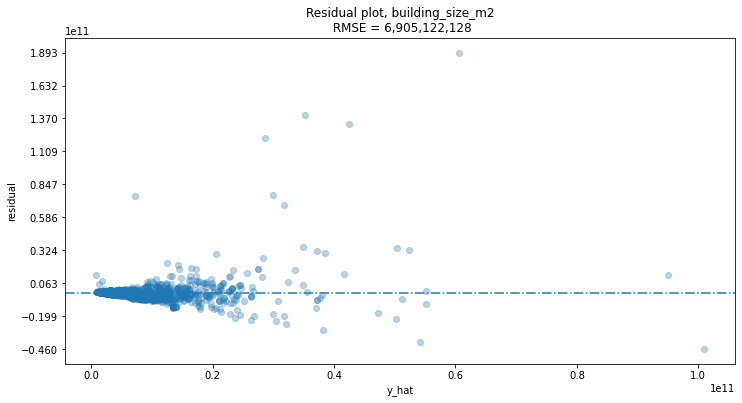

In [112]:
y_hat = results.predict(X).values
resid = y - y_hat
mse = mean_squared_error(y, y_hat)
# matpltlib plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x=y_hat, y=resid, alpha=0.3)
ax.axhline(y=resid.mean(), linestyle='-.')
ax.set_title(f'Residual plot, building_size_m2\n RMSE = {np.sqrt(mse):,.0f}')
ax.set_yticks(np.linspace(resid.min(), resid.max(), 10))
ax.set_xlabel('y_hat')
ax.set_ylabel('residual')

#### **Addressing Non-Linearity of Multiple Regression**

Text(0, 0.5, 'residual')

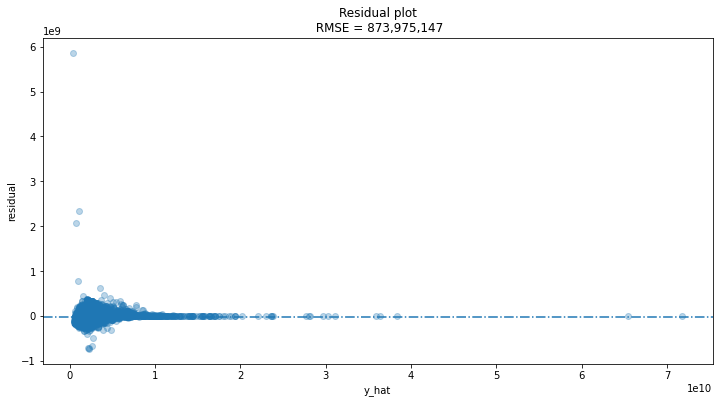

In [113]:
X = X.values
Z = X[:, [3, 4]]# Variables responsible for heteroscedacity
# Robust Regression
reg = HetRobustRegression(fit_intercept=False)
results = reg.fit(X, y, Z)
y_hat = results.predict(X)
weight = results.weight_
weighted_resid = weight * (y - y_hat)
mse = mean_squared_error(y, y_hat, sample_weight=weight)
# matpltlib plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x=y_hat, y=weighted_resid, alpha=0.3)
ax.axhline(y=weighted_resid.mean(), linestyle='-.')
ax.set_title(f'Residual plot\n RMSE = {np.sqrt(mse):,.0f}')
ax.set_xlabel('y_hat')
ax.set_ylabel('residual')

Text(0.5, 0, 'Obs. Number')

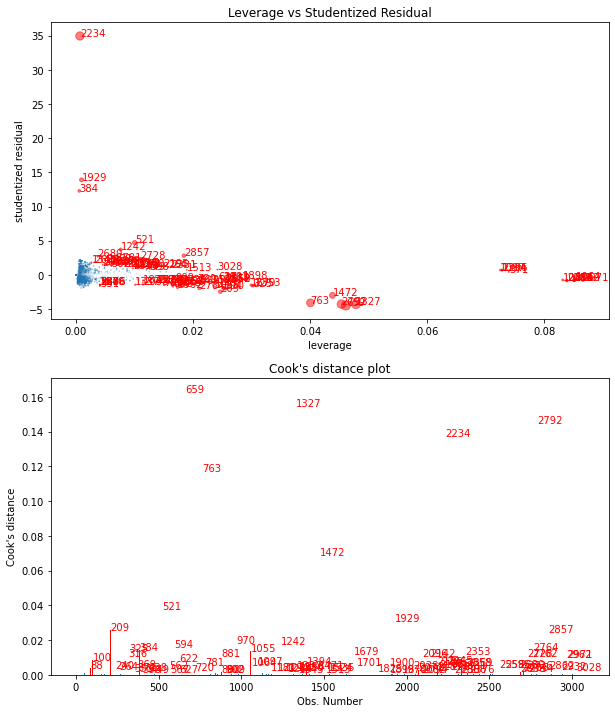

In [114]:
# Cook Distance
W = diags(weight)
p = X.shape[1] # no intercept
resid = weighted_resid
se2 = np.square(np.linalg.norm(resid)) / (len(y) - p) # se2 = SSE / (n - p), p = 1 since no intercept
h = np.diag(X @ np.linalg.inv((X.T) @ W @ X) @ (X.T) @ W) # leverage is (weighted) hat matrix diagonal
student_resid = resid / np.sqrt(se2 * (1 - h))
cooks_dist = (np.square(resid) / (p * se2)) * (h / np.square(1 - h))
high_influence_obs = (cooks_dist > (4 / (X.shape[0] - p)))
high_influence_obs_index = np.where(high_influence_obs)[0]
# High Influence Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
ax[0].scatter(
    x=h[~high_influence_obs], y=student_resid[~high_influence_obs], 
    s= cooks_dist[~high_influence_obs] * 500, alpha=0.5)
ax[0].scatter(
    x=h[high_influence_obs], y=student_resid[high_influence_obs], 
    alpha=0.5, color='r', s=cooks_dist[high_influence_obs] * 500,
    label='high influence')
for lev, stud_resid, index in np.c_[
    h[high_influence_obs], student_resid[high_influence_obs], high_influence_obs_index]:
    ax[0].text(x=lev, y=stud_resid, s=str(int(index)), color='r')
ax[0].set_ylabel('studentized residual')
ax[0].set_xlabel('leverage')
ax[0].set_title('Leverage vs Studentized Residual')
# Cook's distance Plot
obs_index = np.where(y)[0]
ax[1].bar(
    x=obs_index[~high_influence_obs], height=cooks_dist[~high_influence_obs])
ax[1].bar(
    x=obs_index[high_influence_obs], height=cooks_dist[high_influence_obs], 
    color='r', label='Outliers')
for x_, y_ in np.c_[obs_index[high_influence_obs], cooks_dist[high_influence_obs]]:
    ax[1].text(x=x_, y=y_, s=str(int(x_)), color='r')
ax[1].set_title('Cook\'s distance plot')
ax[1].set_ylabel('Cook\'s distance')
ax[1].set_xlabel('Obs. Number')

(0.0, 10000000000.0)

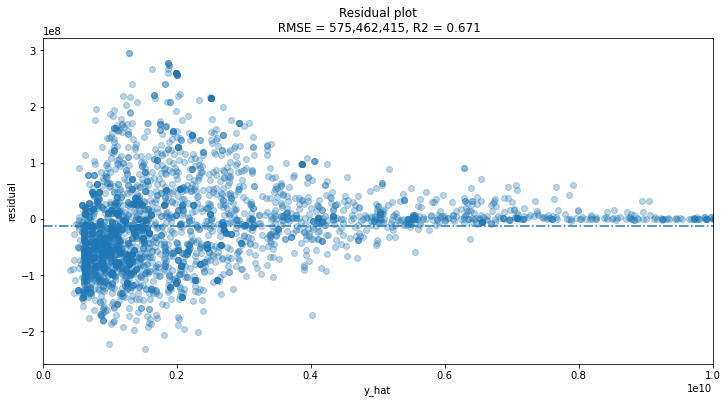

In [115]:
X = X[~high_influence_obs, :]
y = y[~high_influence_obs]
Z = X[:, [3, 4]] # Variables responsible for heteroscedacity
# Robust Regression
reg = HetRobustRegression(fit_intercept=False)
results = reg.fit(X, y, Z)
r2 = results.score(X, y, Z)
y_hat = results.predict(X)
weight = results.weight_
weighted_resid = weight * (y - y_hat)
mse = mean_squared_error(y, y_hat, sample_weight=weight)
# matpltlib plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x=y_hat, y=weighted_resid, alpha=0.3)
ax.axhline(y=weighted_resid.mean(), linestyle='-.')
ax.set_title(f'Residual plot\n RMSE = {np.sqrt(mse):,.0f}, R2 = {r2:.3f}')
ax.set_xlabel('y_hat')
ax.set_ylabel('residual')
ax.set_xlim(0, 1e10)

Next, we will verify 

In [116]:
from sklearn.linear_model import LinearRegression

def coefficient(x, y_null, boot_resid):
    epsilon = np.random.choice([1, -1], len(y_null), p=[0.5, 0.5]) # Flachair's pick distribution
    boot_resid_ = boot_resid.flatten()
    resid_dgp = boot_resid_ * epsilon
    y_dgp = (y_null + resid_dgp).flatten()
    lm_boots = LinearRegression(fit_intercept=False)
    result_boots = lm_boots.fit(x, y_dgp)
    coef_boots = result_boots.coef_
    return coef_boots

# prediction
lm = HetRobustRegression(fit_intercept=False)
results = lm.fit(X, y, Z)
y_predict = results.predict(X) # y_predict here serves beta as the null hypotheses for bootstrap
coef = results.coef_
# calculate hat matrix
h = np.diag(X @ np.linalg.inv((X.T) @ X) @ (X.T)) #  = h_t in Flachair (2003)
# calculate adjusted residual
residual = y - y_predict # = OLS restricted residuals in Flachair (2003)
a = 1/ (1 - h) # using HC3 as proposed by Flachair (2003)
resid = a * residual
# bootstrap
arr = np.empty(len(y))
sample = (arr, )
confidence_level = 0.95
lower_tail = (1 - confidence_level) / 2
upper_tail = 1 - lower_tail 
bootstrap_res = bootstrap(
    sample, lambda arr: coefficient(X, y_predict, resid), vectorized=False, 
    confidence_level=confidence_level, method='percentile'
)

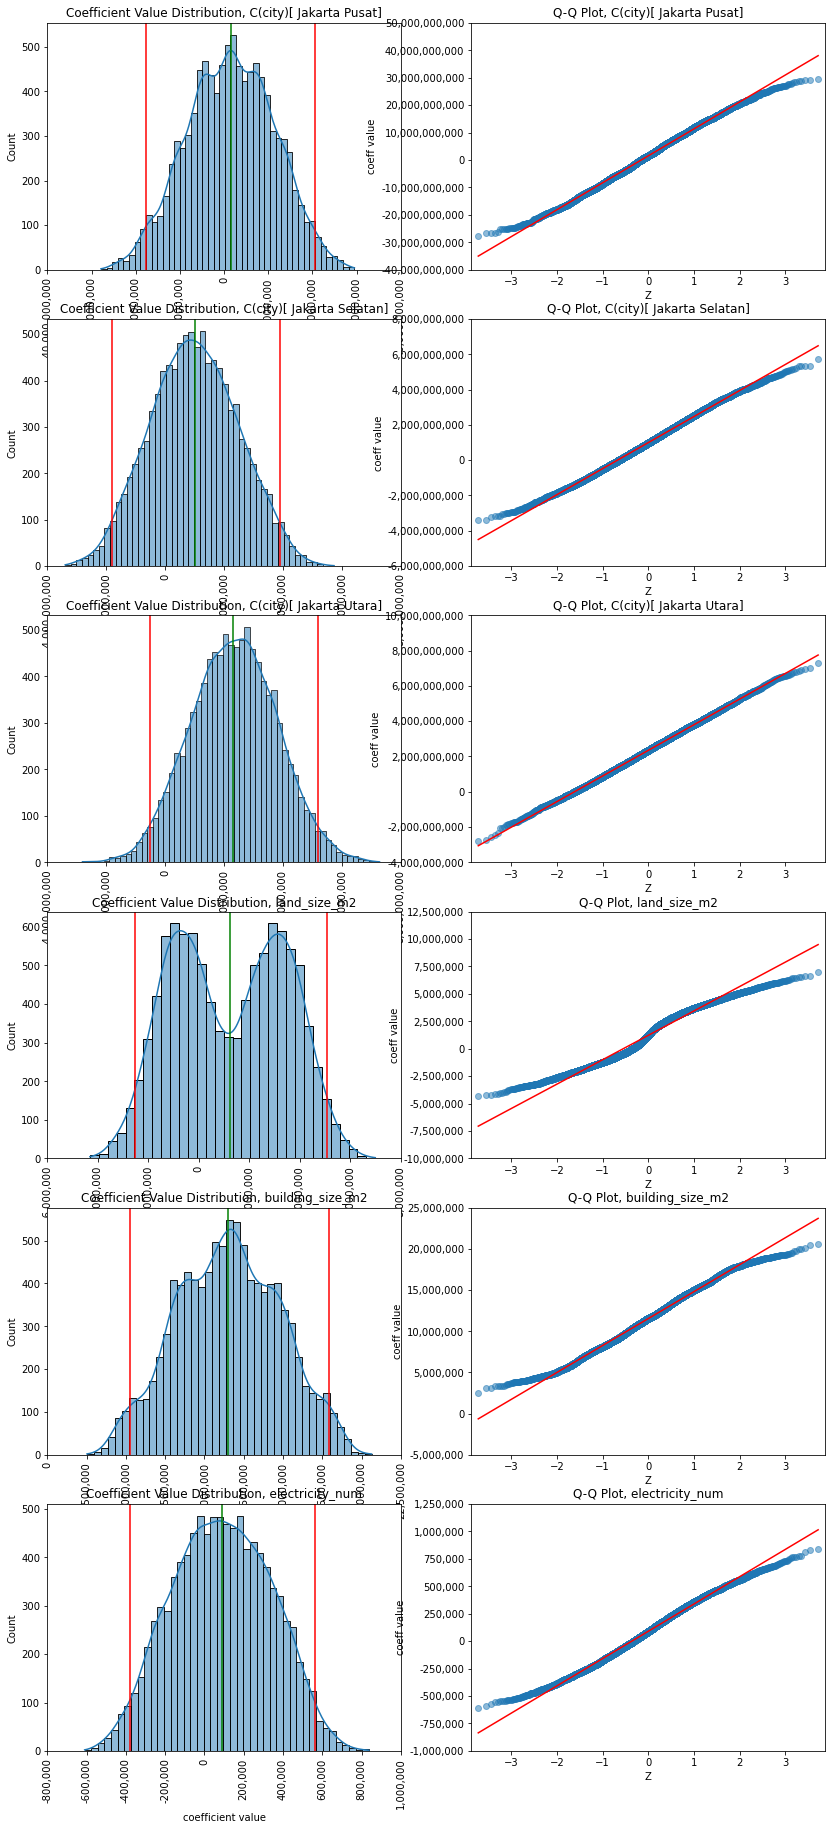

In [117]:
# Features
coef = coef.reshape(-1, 1)
features_name = features.values.reshape(-1, 1)
p = len(features_name)
# bootstrapping
n_iter = 9999
arr = np.empty((n_iter, 1))
bootstrap_coeff_value = \
    np.apply_along_axis(lambda x: coefficient(X, y_predict, resid), 1, arr)
# plotting bootstrap result
conf_low = bootstrap_res.confidence_interval[0].reshape(-1, 1)
conf_high = bootstrap_res.confidence_interval[1].reshape(-1, 1)
coef_array = np.c_[features_name, coef, conf_low, conf_high]
fig, ax = plt.subplots(p, 2, figsize=(16, 6 * p))

for index, (feature, coef, ci_l, ci_h) in enumerate(coef_array):
    sns.histplot(
        x=bootstrap_coeff_value[:, index], kde=True, ax=ax[index, 0]
        )
    ax[index, 0].axvline(coef, color='green')
    ax[index, 0].axvline(ci_l, color='r')
    ax[index, 0].axvline(ci_h, color='r')
    xticks = ax[index, 0].get_xticks()
    ax[index, 0].set_title(f'Coefficient Value Distribution, {feature}')
    ax[index, 0].set_xticks(xticks)
    ax[index, 0].set_xticklabels(['{:,.0f}'.format(x) for x in xticks], rotation=90)
    ax[index, 0].set_xlabel('coefficient value')
    # Q-Q Plot
    pplot = ProbPlot(bootstrap_coeff_value[:, index].flatten())
    pplot.qqplot(ax=ax[index, 1], alpha=0.5, line='s')
    yticks = ax[index, 1].get_yticks()
    ax[index, 1].set_yticks(yticks)
    ax[index, 1].set_yticklabels(['{:,.0f}'.format(y) for y in yticks])
    ax[index, 1].set_title(f'Q-Q Plot, {feature}')
    ax[index, 1].set_xlabel('Z')
    ax[index, 1].set_ylabel('coeff value')
plt.subplots_adjust(wspace=0.3, hspace=0.5)

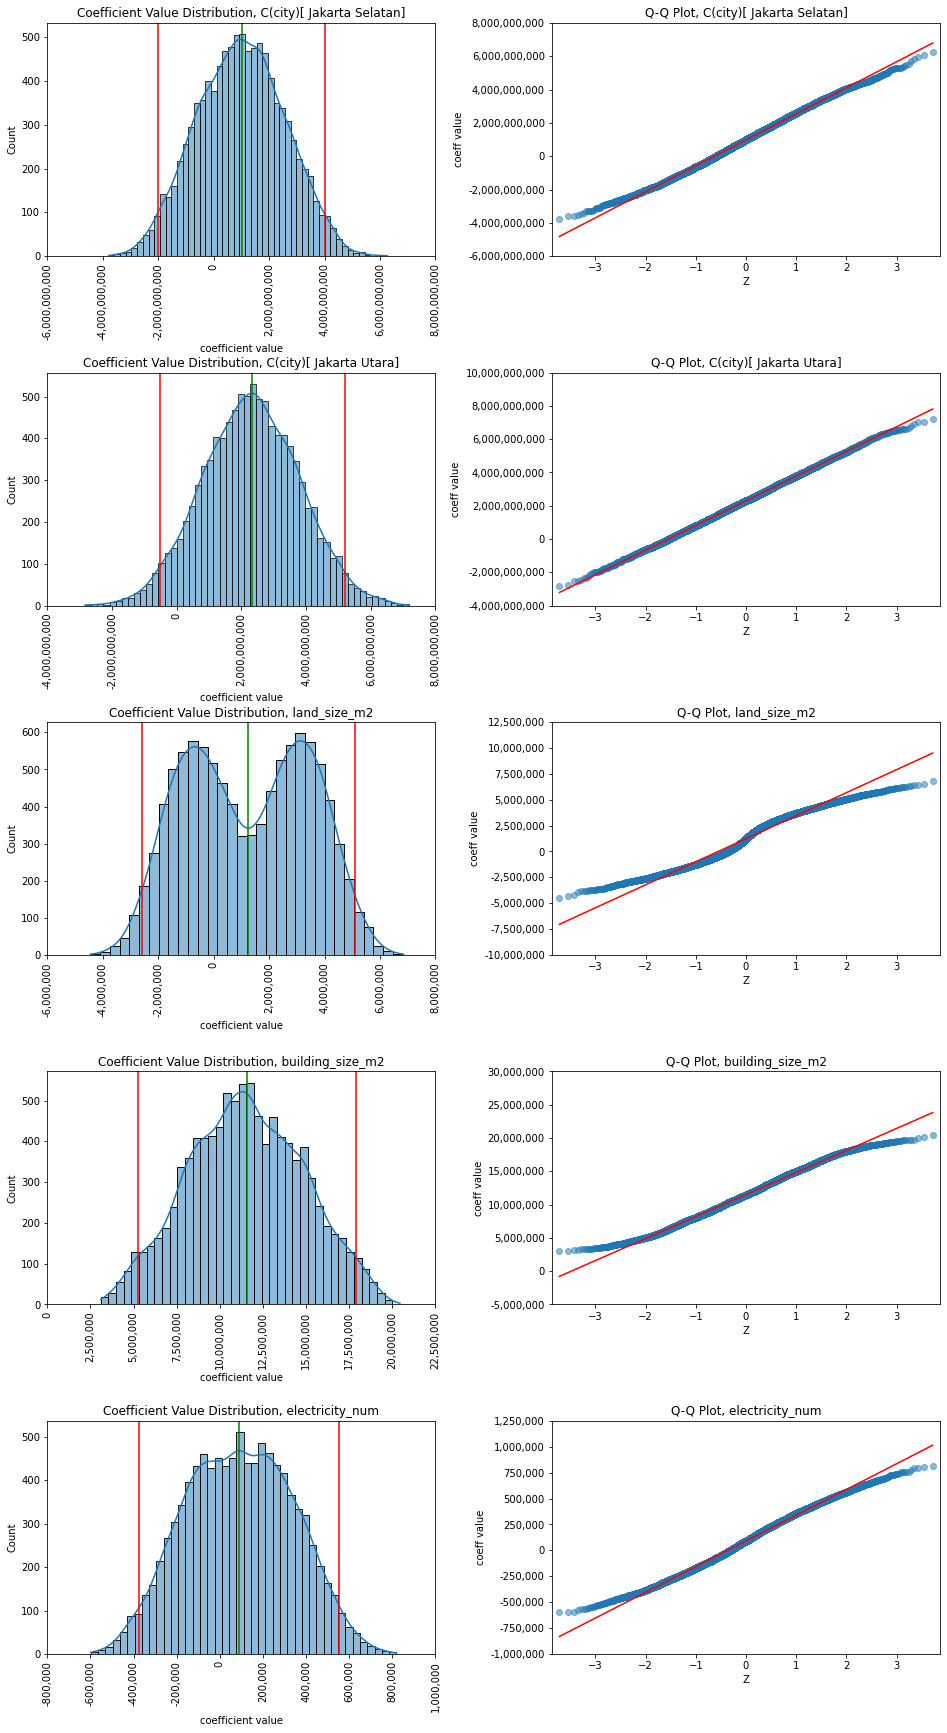

In [132]:
# re-adjust features
y, X = dmatrices(f, train_set_transfd, return_type='dataframe')
X.drop(X.columns[[0, 1, 2, 3, 4, 6, 8]], axis=1, inplace=True)
features = X.columns
X = X.values[~high_influence_obs, :]
y = y.values.flatten()[~high_influence_obs]
Z = X[:, [2, 3]]
# prediction
lm = HetRobustRegression(fit_intercept=False)
results = lm.fit(X, y, Z)
y_predict = results.predict(X) # y_predict here serves beta as the null hypotheses for bootstrap
coef = results.coef_
# calculate hat matrix
h = np.diag(X @ np.linalg.inv((X.T) @ X) @ (X.T)) #  = h_t in Flachair (2003)
# calculate adjusted residual
residual = y - y_predict # = OLS restricted residuals in Flachair (2003)
a = 1/ (1 - h) # using HC3 as proposed by Flachair (2003)
resid = a * residual
# bootstrap ci
arr = np.empty(len(y))
sample = (arr, )
confidence_level = 0.95
lower_tail = (1 - confidence_level) / 2
upper_tail = 1 - lower_tail 
bootstrap_res = bootstrap(
    sample, lambda arr: coefficient(X, y_predict, resid), vectorized=False, 
    confidence_level=confidence_level, method='percentile'
)
# Features
coef = coef.reshape(-1, 1)
features_name = features.values.reshape(-1, 1)
p = len(features_name)
# bootstrap distribution
n_iter = 9999
arr = np.empty((n_iter, 1))
bootstrap_coeff_value = \
    np.apply_along_axis(lambda x: coefficient(X, y_predict, resid), 1, arr)
# plotting bootstrap result
conf_low = bootstrap_res.confidence_interval[0].reshape(-1, 1)
conf_high = bootstrap_res.confidence_interval[1].reshape(-1, 1)
coef_array = np.c_[features_name, coef, conf_low, conf_high]
fig, ax = plt.subplots(p, 2, figsize=(16, 6 * p))
for index, (feature, coef, ci_l, ci_h) in enumerate(coef_array):
    sns.histplot(
        x=bootstrap_coeff_value[:, index], kde=True, ax=ax[index, 0]
        )
    ax[index, 0].axvline(coef, color='green')
    ax[index, 0].axvline(ci_l, color='r')
    ax[index, 0].axvline(ci_h, color='r')
    xticks = ax[index, 0].get_xticks()
    ax[index, 0].set_title(f'Coefficient Value Distribution, {feature}')
    ax[index, 0].set_xticks(xticks)
    ax[index, 0].set_xticklabels(['{:,.0f}'.format(x) for x in xticks], rotation=90)
    ax[index, 0].set_xlabel('coefficient value')
    # Q-Q Plot
    pplot = ProbPlot(bootstrap_coeff_value[:, index].flatten())
    pplot.qqplot(ax=ax[index, 1], alpha=0.5, line='s')
    yticks = ax[index, 1].get_yticks()
    ax[index, 1].set_yticks(yticks)
    ax[index, 1].set_yticklabels(['{:,.0f}'.format(y) for y in yticks])
    ax[index, 1].set_title(f'Q-Q Plot, {feature}')
    ax[index, 1].set_xlabel('Z')
    ax[index, 1].set_ylabel('coeff value')
plt.subplots_adjust(wspace=0.3, hspace=0.5)

In [ ]:
f = 'price_in_rp ~ ' + ' + '.join(numerical_features) + ' - 1 + '
f += 'C(city)' # `Bekasi` as reference

In [133]:
pd.DataFrame(
    coef_array,
    columns=['features_name', 'coef', 'conf_low', 'conf_high']
    ).set_index('features_name')

,coef,conf_low,conf_high
features_name,,,
C(city)[ Jakarta Selatan],"1,008,895,084.88","-2,019,435,651.55","4,021,725,993.05"
C(city)[ Jakarta Utara],"2,318,415,910.91","-520,988,628.19","5,198,466,001.46"
land_size_m2,"1,239,427.49","-2,570,324.53","5,092,279.39"
building_size_m2,"11,548,017.99","5,264,217.76","17,920,181.45"
electricity_num,"88,914.12","-373,683.86","553,353.21"


# 3. Practical Usage of Parametric Model: Way to Maximize House-Selling Profit for Developer